**Titanic - Machine Learning from Disaster** 

Predict survival on the Titanic

Data Dictionary

*   survival: Survival 0 = No, 1 = Yes
*   pclass: Ticket class 1 = 1st, 2 = 2nd, 3 = 3rd
*   sex: Sex
*   Age: Age in years
*   sibsp: # of siblings / spouses aboard the Titanic
*   parch: # of parents / children aboard the Titanic
*   ticket: Ticket number
*   fare: Passenger fare
*   cabin: Cabin number
*   embarked: Port of Embarkation C = Cherbourg, Q = Queenstown, S = Southampton


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**1. Import libraries and Dataset**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

train_path = '/content/drive/MyDrive/dataML/Titanic/train.csv'
test_path = '/content/drive/MyDrive/dataML/Titanic/test.csv'
data_train =  pd.read_csv(train_path)
data_test = pd.read_csv(test_path)

**2. Looking into the training and test dataset** 

Printing first 5 rows of the train and test datasets.

In [3]:
data_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


**3. Describing  datasets**

In [5]:
# combining train and test dataset
train_test_data = [data_train, data_test]

print(" Train data: \n Size: Number of rows %d; Number of columns %d."%data_train.shape)

print(data_train.isnull().sum(),'\n')

print(" Test data: \n Size: Number of rows %d; Number of columns %d."%data_test.shape)
print(data_test.isnull().sum())

 Train data: 
 Size: Number of rows 891; Number of columns 12.
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64 

 Test data: 
 Size: Number of rows 418; Number of columns 11.
PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


We can see that there are:
1.  891 rows and 12 columns in training dataset;
2.  418 rows and 11 columns in testing dataset.

Training dataset :
*   177 rows with missing Age
*   687 rows with missing Cabin
*   2 rows with missing Embarked 

Testing dataset : 
*   86 rows with missing Age
*   1 row with missing Fare
*   327 rows with missing Cabin





**4. Bar Chart for Categorical Features**

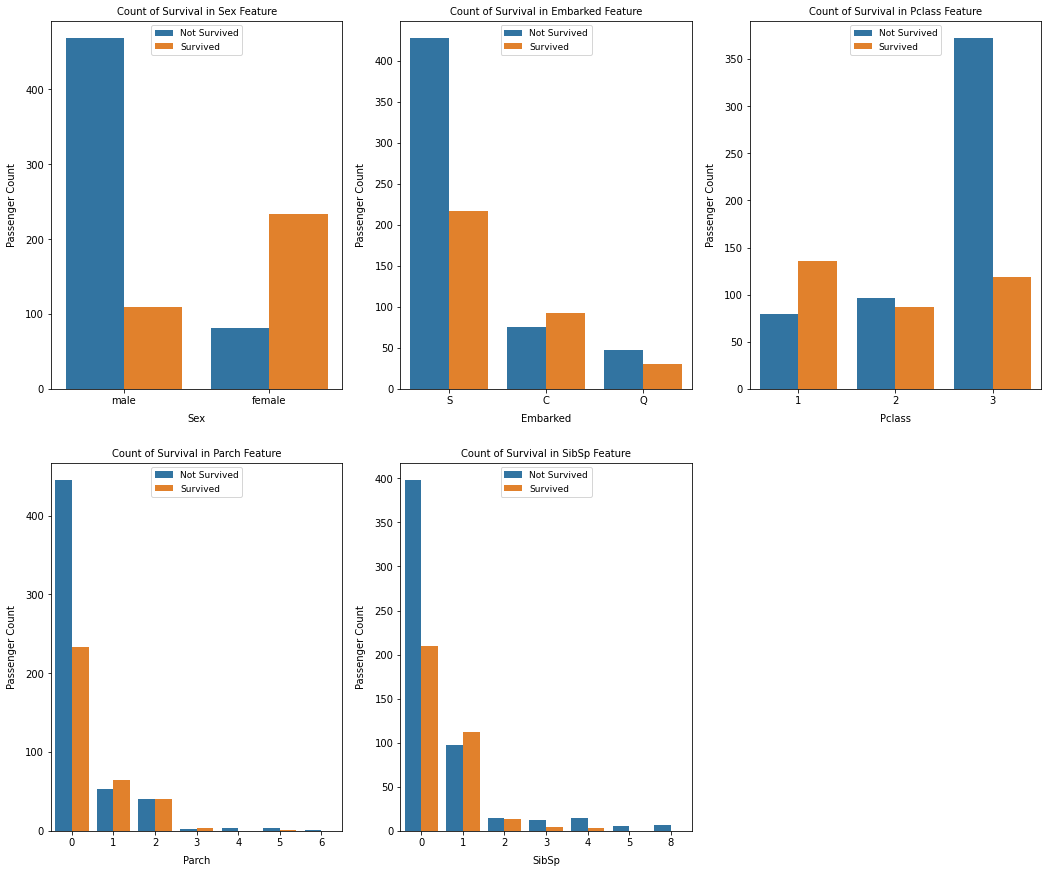

In [6]:
cat_features = ['Sex','Embarked','Pclass', 'Parch', 'SibSp']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(10, 10))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=data_train)
    
    plt.xlabel('{}'.format(feature), size=10, labelpad=8)
    plt.ylabel('Passenger Count', size=10, labelpad=8)    
    plt.tick_params(axis='x', labelsize=10)
    plt.tick_params(axis='y', labelsize=10)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 9})
    plt.title('Count of Survival in {} Feature'.format(feature), size=10)
plt.show()

The Charts  confirm : 
1.   Females have better survival chance;
2.   A person aboarded from C slightly more likely survived, but person aboarded from S and Q more likely dead;
3.   1st class more likely survivied than other classes. 3rd class more likely dead than other classes;
4.   Most people traveled alone or with one of their siblings or spouse;
5.   The chances of survival plummeted if someone traveled with more than two relatives. 

     



**5. Feature engineering**

Filling missing values
- fill missing age with median age
- category "S" has maximum passengers. Hence, we replace "NAN" values with "S"
- fill missing Fare with median fare for each Pclass

We will skip the Cabin feature since there are a large number of missing values.

In [7]:
#Sex
sex_mapping = {"male": 0, "female": 1}
for dataset in train_test_data:
    dataset['Sex'] = dataset['Sex'].map(sex_mapping)

# Age
data_train['Age'].fillna(data_train['Age'].median(), inplace=True)
data_test['Age'].fillna(data_test['Age'].median(), inplace=True)
# Embarked
data_train['Embarked'].describe()
data_train['Embarked'].fillna('S', inplace=True)

embarked_mapping = {"S": 0, "C": 1, "Q": 2}
for dataset in train_test_data:
    dataset['Embarked'] = dataset['Embarked'].map(embarked_mapping)

# Fare
data_test["Fare"].fillna(data_test.groupby("Pclass")["Fare"].transform("median"), inplace=True)

We create a new feature named FamilySize (Combining SibSp & Parch feature)


In [8]:
data_train["FamilySize"] = data_train["SibSp"] + data_train["Parch"] + 1
data_test["FamilySize"] = data_test["SibSp"] + data_test["Parch"] + 1

print (data_train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000


- Having FamilySize upto 4 (from 2 to 4) has better survival chance.
- FamilySize = 1, i.e. travelling alone has less survival chance.
- Large FamilySize (size of 5 and above) also have less survival chance.

**6. Feature Selection**

We drop unnecessary columns/features and keep only the useful ones.Column PassengerId is only dropped from Train set because we need PassengerId in Test set while creating Submission.

In [9]:
features_drop = ['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'FamilySize']
train = data_train.drop(features_drop, axis=1)
test = data_test.drop(features_drop, axis=1)
train = train.drop(['PassengerId'], axis=1)

train.head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0,3,0,22.0,7.2500,0
1,1,1,1,38.0,71.2833,1
2,1,3,1,26.0,7.9250,0
3,1,1,1,35.0,53.1000,0
4,0,3,0,35.0,8.0500,0


In [10]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked
0,892,3,0,34.5,7.8292,2
1,893,3,1,47.0,7.0000,0
2,894,2,0,62.0,9.6875,2
3,895,3,0,27.0,8.6625,0
4,896,3,1,22.0,12.2875,0


Define training and testing set

In [11]:
X_train = train.drop('Survived', axis=1)
y_train = train['Survived']
X_test = test.drop("PassengerId", axis=1).copy()

# Size of X_train, y_train and X_test
X_train.shape, y_train.shape, X_test.shape

((891, 5), (891,), (418, 5))

**7. Modelling**

There are many classifying algorithms present. Among them, we choose the following Classification algorithms :
- Logistic Regression
- k-Nearest Neighbor (KNN)
- Decision Tree
- Random Forest
- Naive Bayes (GaussianNB)
- Support Vector Machines (SVC)

In [12]:
# Importing Classifier Modules
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# Logistic Regression
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred_log_reg = clf.predict(X_test)
acc_log_reg = round( clf.score(X_train, y_train) * 100, 2)

# k -Nearest Neighbors
clf = KNeighborsClassifier(n_neighbors = 3)
clf.fit(X_train, y_train)
y_pred_knn = clf.predict(X_test)
acc_knn = round(clf.score(X_train, y_train) * 100, 2)

# Decision Tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred_decision_tree = clf.predict(X_test)
acc_decision_tree = round(clf.score(X_train, y_train) * 100, 2)

# Random Forest
clf = RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
y_pred_random_forest = clf.predict(X_test)
acc_random_forest = round(clf.score(X_train, y_train) * 100, 2)

# Gaussian Naive Bayes
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_gnb = clf.predict(X_test)
acc_gnb = round(clf.score(X_train, y_train) * 100, 2)

# Support Vector Machine (SVM)
clf = SVC()
clf.fit(X_train, y_train)
y_pred_svc = clf.predict(X_test)
acc_svc = round(clf.score(X_train, y_train) * 100, 2)

Comparing Models

In [13]:
models = pd.DataFrame({
    'Model': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Naive Bayes', 'Support Vector Machines'],
    'Score': [acc_log_reg, acc_knn,  acc_decision_tree, acc_random_forest, acc_gnb, acc_svc] })

models.sort_values(by='Score', ascending=False)

,Model,Score
2,Decision Tree,97.76
3,Random Forest,97.76
1,KNN,83.73
0,Logistic Regression,79.12
4,Naive Bayes,77.67
5,Support Vector Machines,68.13


From the above table, we can see that Decision Tree and Random Forest classfiers have the highest accuracy score.

Among these two, we choose Random Forest classifier as it has the ability to limit overfitting as compared to Decision Tree classifier.

**8. Create Submission File**

In [14]:
submission = pd.DataFrame({"PassengerId": test["PassengerId"],"Survived": y_pred_random_forest})
#submission = pd.DataFrame({"PassengerId": test["PassengerId"],"Name": data_test["Name"],"Survived": y_pred_random_forest})
submission.head(15)
# submission.to_csv('submission.csv', index=False)


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1
5,897,0
6,898,0
7,899,0
8,900,1
9,901,0
